In [17]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd

data_lundi = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')
data_mercredi = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')

dataset = pd.concat([data_lundi, data_mercredi], ignore_index=True)

dataset.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [19]:
N = len(dataset.index)
print(f"Number of samples : {N}.")

N_feat = len(dataset.columns.values)
print(f"Number of features : {N_feat}.")  

categories = dataset[' Label'].unique()
print("Different Categories:", categories)

Number of samples : 1222621.
Number of features : 79.
Different Categories: <StringArray>
[          'BENIGN',    'DoS slowloris', 'DoS Slowhttptest',
         'DoS Hulk',    'DoS GoldenEye',       'Heartbleed']
Length: 6, dtype: str



Counts per category:
 Label
BENIGN              969949
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


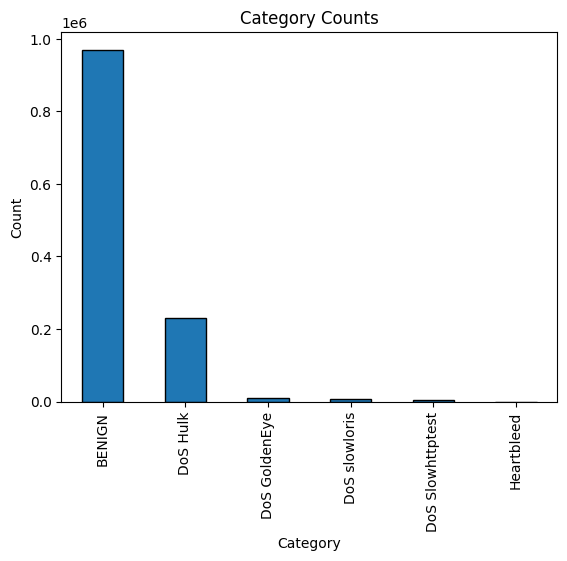

In [20]:
import matplotlib.pyplot as plt

category_counts = dataset[' Label'].value_counts()
print("\nCounts per category:")
print(category_counts)

category_counts.plot(kind='bar', edgecolor='black')
plt.title("Category Counts")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


In [21]:
missing_values_headers = []
headers = dataset.columns.values.tolist()

for header in headers:
    if dataset[header].isnull().any():
        missing_values_headers.append(header)

print(f"Les attributs contenant des valeurs manquantes sont {missing_values_headers}.")

print(len(dataset))
#df = df.dropna(subset = ['Flow Bytes/s'])
print(len(dataset))

Les attributs contenant des valeurs manquantes sont ['Flow Bytes/s'].
1222621
1222621


Preprocessing
-------------

Volé chez Tristan

In [22]:
# Data cleaning
# Create a copy to avoid modifying the original dataset
df_processed = dataset.copy()

print(f"Initial shape: {df_processed.shape}")

# Handle missing values
missing_before = df_processed.isnull().sum().sum()
print(f"\nMissing values before cleaning: {missing_before}")

# Fill or drop missing values (strategy: drop rows with missing values)
df_processed = df_processed.dropna()
print(f"Missing values after cleaning: {df_processed.isnull().sum().sum()}")

# Handle infinite values
print(f"\nHandling infinite values...")
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(' Label', errors='ignore')

# Replace infinite values with NaN, then replace with column median
for col in numerical_cols:
    inf_mask = df_processed[col].isin([float('inf'), float('-inf')])
    if inf_mask.any():
        print(f"  - Found {inf_mask.sum()} infinite values in '{col}'")
        df_processed.loc[inf_mask, col] = df_processed[col].replace([float('inf'), float('-inf')], float('nan'))
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

print(f"\nFinal shape after cleaning: {df_processed.shape}")
print(f"Rows removed: {len(dataset) - len(df_processed)}")

Initial shape: (1222621, 79)

Missing values before cleaning: 1072
Missing values after cleaning: 0

Handling infinite values...
  - Found 662 infinite values in 'Flow Bytes/s'
  - Found 662 infinite values in ' Flow Packets/s'


C:\Users\ianis\AppData\Local\Temp\ipykernel_38968\161017512.py:26: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df_processed[col].fillna(df_processed[col].median(), inplace=True)
C:\Users\ianis\AppData\Local\Temp\ipykernel_38968\161017512.py:26: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through 


Final shape after cleaning: (1221549, 79)
Rows removed: 1072


In [23]:
# Separate features (X) and labels (y)
X = df_processed.drop(' Label', axis=1)
y = df_processed[' Label']

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:")
print(y.value_counts())

Features shape: (1221549, 78)
Labels shape: (1221549,)

Label distribution:
 Label
BENIGN              969826
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


In [24]:
# Encoding categorical features

# Check for categorical features in X
categorical_features = X.select_dtypes(include=['object']).columns
print(f"\nCategorical features in X: {list(categorical_features)}")

if len(categorical_features) > 0:
    print(f"Found {len(categorical_features)} categorical feature(s) to encode")
    # Apply One-Hot Encoding for categorical features if any exist
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        print(f"  - Encoded '{col}'")
else:
    print("No categorical features found in features (X) - all features are numerical")

# Encode target labels (y) - convert attack names to numerical labels
print(f"\nEncoding target labels (y)...")
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"  {label:20s} → {idx}")

print(f"\nEncoded labels shape: {y_encoded.shape}")


Categorical features in X: []
No categorical features found in features (X) - all features are numerical

Encoding target labels (y)...
Label mapping:
  BENIGN               → 0
  DoS GoldenEye        → 1
  DoS Hulk             → 2
  DoS Slowhttptest     → 3
  DoS slowloris        → 4
  Heartbleed           → 5

Encoded labels shape: (1221549,)


In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, precision_recall_fscore_support)
import seaborn as sns
import numpy as np

In [30]:
# Feature Standardization (Z-Score Normalization)
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

print(f"Original features shape: {X.shape}")
print(f"Scaled features shape: {X_scaled.shape}")

# Show statistics before and after scaling
print(f"\nBefore scaling (first feature):")
print(f"  Mean: {X.iloc[:, 0].mean():.4f}")
print(f"  Std:  {X.iloc[:, 0].std():.4f}")
print(f"  Min:  {X.iloc[:, 0].min():.4f}")
print(f"  Max:  {X.iloc[:, 0].max():.4f}")

print(f"\nAfter scaling (first feature):")
print(f"  Mean: {X_scaled[:, 0].mean():.4f}")
print(f"  Std:  {X_scaled[:, 0].std():.4f}")
print(f"  Min:  {X_scaled[:, 0].min():.4f}")
print(f"  Max:  {X_scaled[:, 0].max():.4f}")

print("\n✓ Features standardized using StandardScaler (mean=0, std=1)")

Original features shape: (1221549, 78)
Scaled features shape: (1221549, 78)

Before scaling (first feature):
  Mean: 7839.1923
  Std:  18564.1924
  Min:  0.0000
  Max:  65535.0000

After scaling (first feature):
  Mean: -0.0000
  Std:  1.0000
  Min:  -0.4223
  Max:  3.1079

✓ Features standardized using StandardScaler (mean=0, std=1)


In [31]:
# Dataset Splitting (70% Train, 15% Validation, 15% Test)

# First split: separate test set (15% of total data)
# stratify ensures attack distribution is maintained in all sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded
)

# Second split: separate training and validation from remaining 85%
# 70% train + 15% validation = 85% total
# To get 15% validation from 85%: 15/85 ≈ 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_temp
)

print(f"\nDataset split completed:")
print(f"  Training set:   {X_train.shape[0]:6,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:6,} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Test set:       {X_test.shape[0]:6,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Total:          {len(X_scaled):6,} samples (100.0%)")

# Verify stratification - check label distribution in each set
print(f"\nLabel distribution verification:")

for set_name, y_set in [("Training", y_train), ("Validation", y_val), ("Test", y_test)]:
    unique, counts = np.unique(y_set, return_counts=True)
    print(f"\n  {set_name} set:")
    for label_idx, count in zip(unique, counts):
        label_name = label_encoder.classes_[label_idx]
        percentage = (count / len(y_set)) * 100
        print(f"    {label_name:20s}: {count:6,} ({percentage:5.2f}%)")


Dataset split completed:
  Training set:   855,572 samples (70.0%)
  Validation set: 182,744 samples (15.0%)
  Test set:       183,233 samples (15.0%)
  Total:          1,221,549 samples (100.0%)

Label distribution verification:

  Training set:
    BENIGN              : 679,266 (79.39%)
    DoS GoldenEye       :  7,209 ( 0.84%)
    DoS Hulk            : 161,179 (18.84%)
    DoS Slowhttptest    :  3,851 ( 0.45%)
    DoS slowloris       :  4,060 ( 0.47%)
    Heartbleed          :      7 ( 0.00%)

  Validation set:
    BENIGN              : 145,086 (79.39%)
    DoS GoldenEye       :  1,540 ( 0.84%)
    DoS Hulk            : 34,426 (18.84%)
    DoS Slowhttptest    :    823 ( 0.45%)
    DoS slowloris       :    867 ( 0.47%)
    Heartbleed          :      2 ( 0.00%)

  Test set:
    BENIGN              : 145,474 (79.39%)
    DoS GoldenEye       :  1,544 ( 0.84%)
    DoS Hulk            : 34,519 (18.84%)
    DoS Slowhttptest    :    825 ( 0.45%)
    DoS slowloris       :    869 ( 0.47%)
  

Random Forest for Intrusion Detection
-------------------------------------

**Tuto**
https://labex.io/fr/tutorials/python-how-to-train-random-forest-in-scikit-learn-425422

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,   # Number of trees
    max_depth=10,
    min_samples_split=2,
    random_state=42
)

In [35]:
# Train the Random Forest model

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [48]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

target_names = label_encoder.classes_
## Predictions
y_tree_pred = rf_model.predict(X_test)

## Performance metrics
print("Accuracy:", accuracy_score(y_test, y_tree_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_tree_pred, target_names=target_names))

Accuracy: 0.9976423460839478

Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    145474
   DoS GoldenEye       1.00      0.94      0.97      1544
        DoS Hulk       0.99      1.00      1.00     34519
DoS Slowhttptest       0.99      0.95      0.97       825
   DoS slowloris       1.00      0.94      0.97       869
      Heartbleed       1.00      1.00      1.00         2

        accuracy                           1.00    183233
       macro avg       1.00      0.97      0.98    183233
    weighted avg       1.00      1.00      1.00    183233



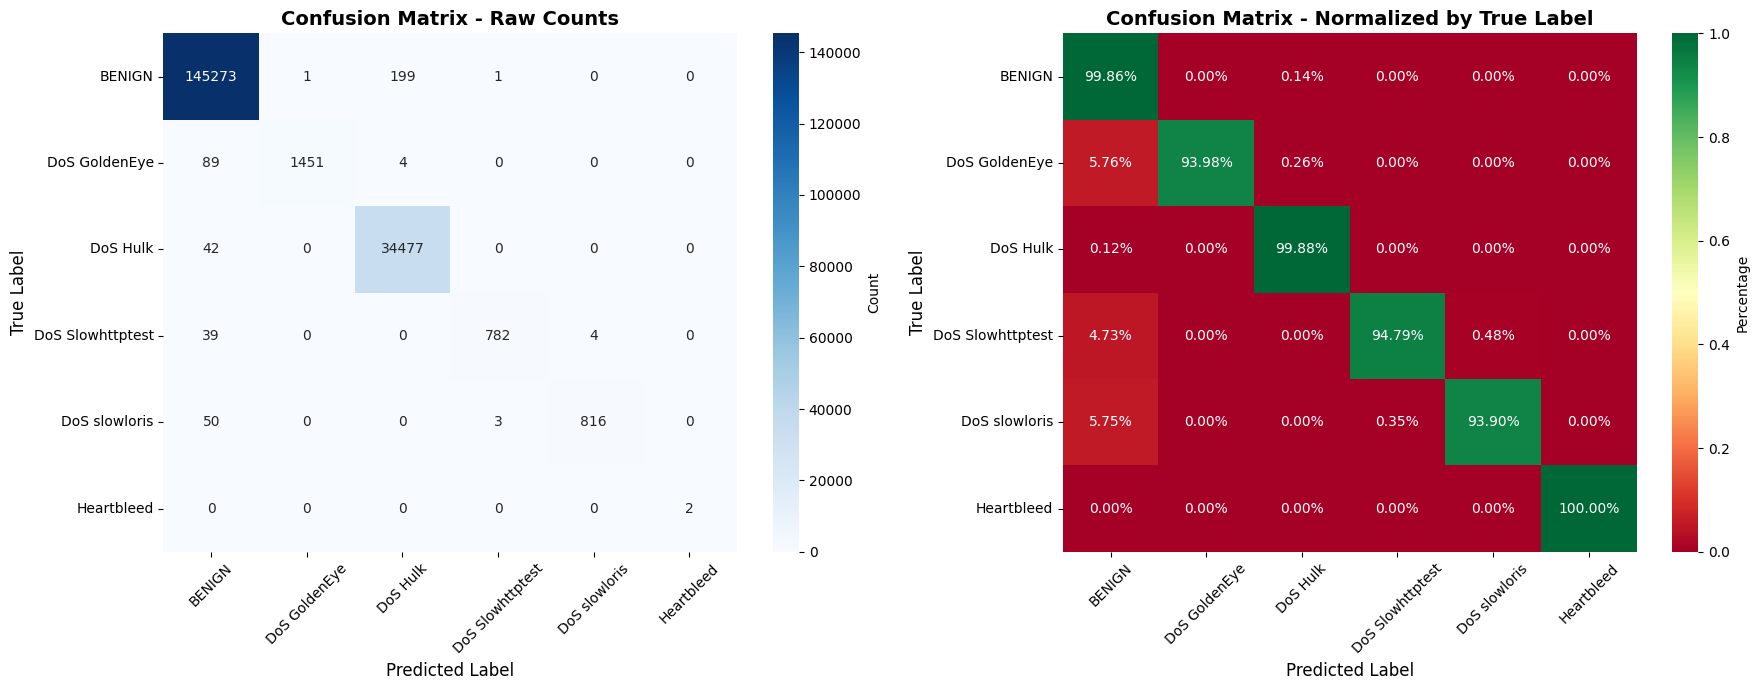


Key Observations from Confusion Matrix:
BENIGN              : 145,273/145,474 correct (99.86%)
DoS GoldenEye       :  1,451/ 1,544 correct (93.98%)
DoS Hulk            : 34,477/34,519 correct (99.88%)
DoS Slowhttptest    :    782/   825 correct (94.79%)
DoS slowloris       :    816/   869 correct (93.90%)
Heartbleed          :      2/     2 correct (100.00%)


In [49]:
# Confusion Matrix Visualization

# Compute confusion matrix
cm = confusion_matrix(y_test, y_tree_pred)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Plot 2: Normalized (percentage per true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix - Normalized by True Label', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Print key observations
print("\nKey Observations from Confusion Matrix:")

# Diagonal elements (correct predictions)
correct_predictions = np.diag(cm)
total_per_class = cm.sum(axis=1)

for i, class_name in enumerate(target_names):
    accuracy_per_class = correct_predictions[i] / total_per_class[i] if total_per_class[i] > 0 else 0
    print(f"{class_name:20s}: {correct_predictions[i]:6,}/{total_per_class[i]:6,} correct ({accuracy_per_class*100:5.2f}%)")

3.2 Feature Importance Analysis 
-------------------------------

In [50]:
feature_importance = rf_model.feature_importances_
feature_names = X.columns

## Sort features by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

importance_df.head(5) # 5 most influential features

,feature,importance
39,Max Packet Length,0.078029
41,Packet Length Std,0.074712
10,Bwd Packet Length Max,0.064432
54,Avg Bwd Segment Size,0.063540
42,Packet Length Variance,0.054485
